In [163]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text
from matplotlib.colors import LogNorm
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

from dpat.mil.models import CCMIL

In [5]:
model = CCMIL(hidden_features=1024, num_classes=2, T_max=3000, dropout=0.5)

Some weights of the model checkpoint at nlpie/tiny-clinicalbert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at nlpie/tiny-clinicalbert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weig

In [92]:
df = pd.read_csv("/home/sdejong/pmchhg/labels.csv")
df["embeddings"] = df["location"].apply(lambda x: model.compute_cc_embedding(x).numpy())

In [146]:
X, index = np.unique(np.concatenate(df["embeddings"]), axis=0, return_index=True)

In [156]:
tsne = TSNE(n_iter=10000, perplexity=8, random_state=42)
tsne_transformed = tsne.fit_transform(X)

In [202]:
gm = GaussianMixture(n_components=6)
gm = gm.fit(tsne_transformed)

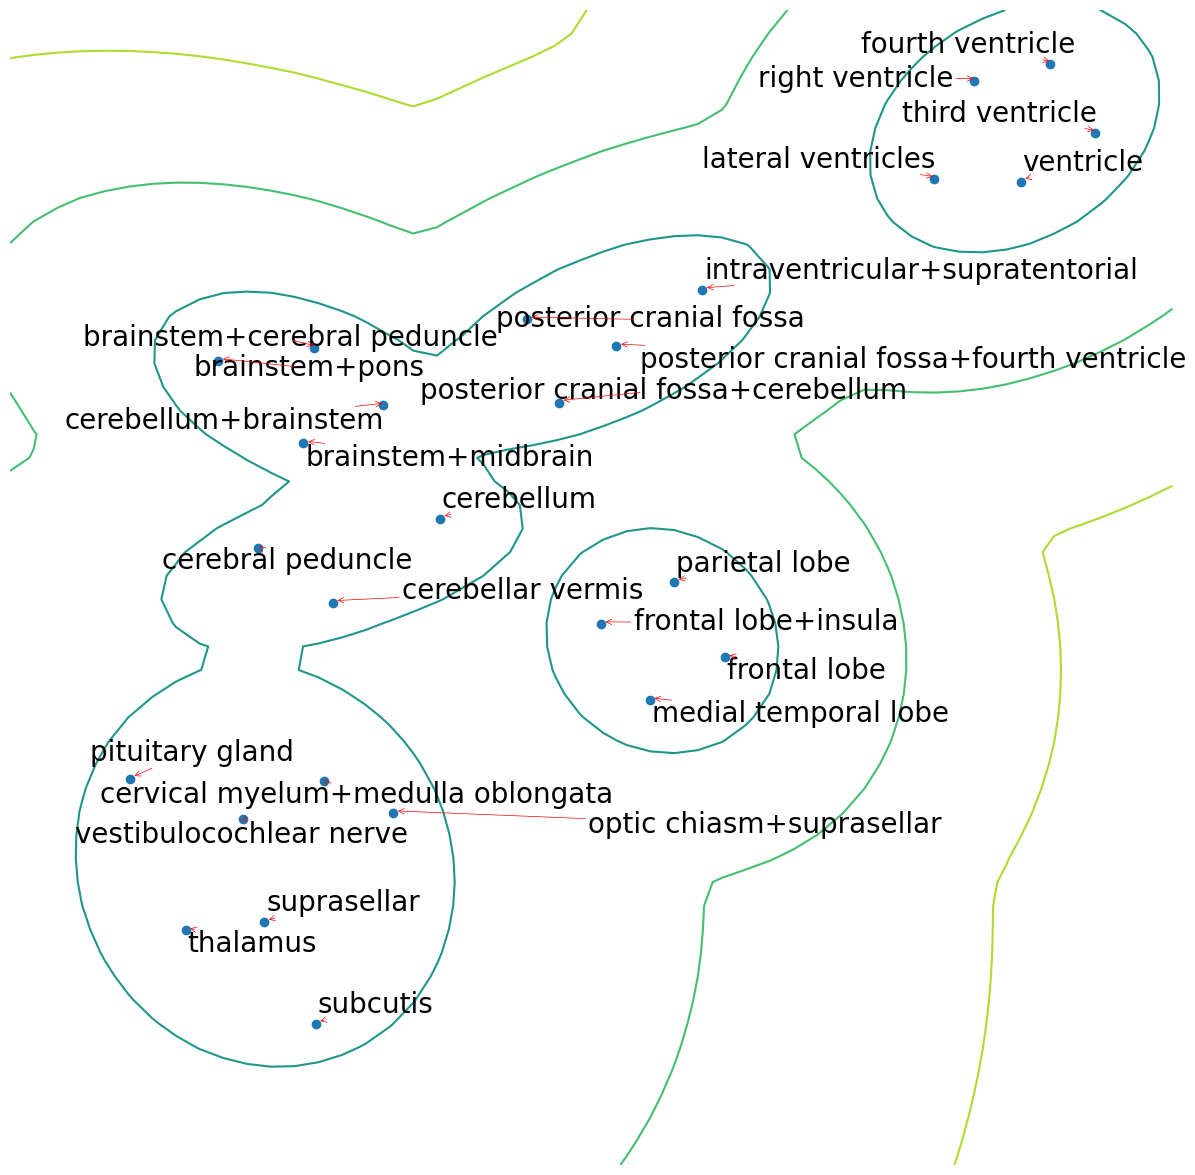

In [201]:
plt.figure(figsize=(15, 15))

# Points
plt.scatter(*tsne_transformed.T)
texts = []
for i, location in enumerate(df["location"][index]):
    texts.append(plt.text(*tsne_transformed[i] + (0.2, 0.2), location, fontsize=20))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, force_points=0.20,
            arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

# Gaussian mixture
x = np.linspace(-40, 80)
y = np.linspace(-80, 20)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gm.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=80.0), levels=np.logspace(1, 3, 7))

plt.axis("off")
plt.savefig("outputs/15/tsne-cc.pdf", bbox_inches="tight", dpi=300)